In [ ]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd
from os import listdir
import cv2
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Dropout, Activation, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install efficientnet

In [ ]:
# Import the model  
import efficientnet.keras as efn 


pre_trained_model = efn.EfficientNetB7(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = 'imagenet')


# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False
  
# Print the model summary
pre_trained_model.summary()

Model: "efficientnet-b7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 75, 75, 64)   1728        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 75, 75, 64)   256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 75, 75, 64)   0           stem_bn[0][0]                    
____________________________________________________________________________________

In [ ]:
def data_summary(main_path):
    
    yes_path = main_path+'yesreal'
    no_path = main_path+'noreal'
        
    # number of files (images) that are in the the folder named 'yes' that represent tumorous (positive) examples
    m_pos = len(listdir(yes_path))
    # number of files (images) that are in the the folder named 'no' that represent non-tumorous (negative) examples
    m_neg = len(listdir(no_path))
    # number of all examples
    m = (m_pos+m_neg)
    
    pos_prec = (m_pos* 100.0)/ m
    neg_prec = (m_neg* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {m_pos}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {m_neg}") 
    
augmented_data_path = '/content/drive/My Drive/trial1/augmented data1/'    
data_summary(augmented_data_path)

Number of examples: 2064
Percentage of positive examples: 52.56782945736434%, number of pos examples: 1085
Percentage of negative examples: 47.43217054263566%, number of neg examples: 979


In [ ]:
print("The number of MRI images in the training set labelled 'yes':", len(os.listdir('/content/drive/My Drive/trial1/augmented data1/training/yes1')))
print("The number of MRI images in the test set labelled 'yes':", len(os.listdir('/content/drive/My Drive/trial1/augmented data1/testing/yes1')))
print("The number of MRI images in the training set labelled 'no':", len(os.listdir('/content/drive/My Drive/trial1/augmented data1/training/no1')))
print("The number of MRI images in the test set labelled 'no':", len(os.listdir('/content/drive/My Drive/trial1/augmented data1/testing/no1')))

The number of MRI images in the training set labelled 'yes': 868
The number of MRI images in the test set labelled 'yes': 217
The number of MRI images in the training set labelled 'no': 783
The number of MRI images in the test set labelled 'no': 196


In [ ]:
from keras import layers
from keras.optimizers import SGD
x = layers.Flatten()(pre_trained_model.output)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
x = layers.Dense(1, activation='sigmoid')(x)             

model = Model( pre_trained_model.input, x) 
opt = SGD(lr=0.001, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["acc"])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 75, 75, 64)   1728        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 75, 75, 64)   256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 75, 75, 64)   0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [ ]:
TRAINING_DIR = "/content/drive/My Drive/trial1/augmented data1/training"
train_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR, 
                                                    batch_size=64, 
                                                    class_mode='binary', 
                                                    target_size=(150, 150))
VALIDATION_DIR = "/content/drive/My Drive/trial1/augmented data1/testing"
validation_datagen = ImageDataGenerator(rescale=1.0/255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, 
                                                         batch_size=64, 
                                                         class_mode='binary', 
                                                         target_size=(150, 150))

Found 1651 images belonging to 2 classes.
Found 413 images belonging to 2 classes.


In [ ]:
history = model.fit(train_generator,
                              epochs=30,
                              steps_per_epoch=len(train_generator),
                              validation_steps=len(validation_generator),
                              validation_data=validation_generator)

Epoch 1/30
26/26 [==============================] - 53s 2s/step - loss: 0.6688 - acc: 0.6015 - val_loss: 1.2620 - val_acc: 0.4746
Epoch 2/30
26/26 [==============================] - 35s 1s/step - loss: 0.5077 - acc: 0.7547 - val_loss: 0.8688 - val_acc: 0.4818
Epoch 3/30
26/26 [==============================] - 35s 1s/step - loss: 0.4110 - acc: 0.8080 - val_loss: 1.4643 - val_acc: 0.4746
Epoch 4/30
26/26 [==============================] - 34s 1s/step - loss: 0.3716 - acc: 0.8401 - val_loss: 1.3923 - val_acc: 0.4915
Epoch 5/30
26/26 [==============================] - 34s 1s/step - loss: 0.3665 - acc: 0.8310 - val_loss: 2.2876 - val_acc: 0.4818
Epoch 6/30
26/26 [==============================] - 35s 1s/step - loss: 0.3389 - acc: 0.8492 - val_loss: 2.0442 - val_acc: 0.4770
Epoch 7/30
26/26 [==============================] - 34s 1s/step - loss: 0.3330 - acc: 0.8534 - val_loss: 1.4389 - val_acc: 0.5133
Epoch 8/30
26/26 [==============================] - 34s 1s/step - loss: 0.3497 - acc: 0.85

Training Accuracy:  92.0048475265503 %
Validation Accuracy:  84.98789072036743 %
Training Loss:  0.19277428451593828
Validation Loss:  0.341862291097641


Text(0.5, 1.0, 'Training and validation loss')

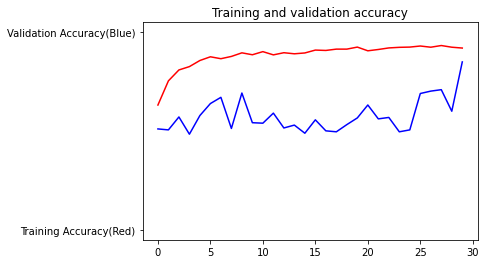

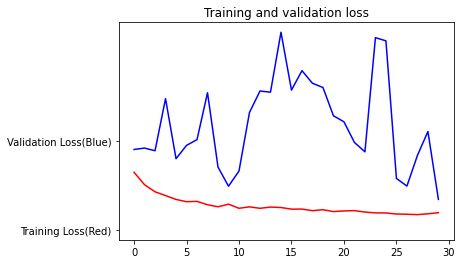

In [ ]:
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']
print("Training Accuracy: ",acc[-1]*100,"%")
print("Validation Accuracy: ",val_acc[-1]*100,"%")
print("Training Loss: ",loss[-1])
print("Validation Loss: ",val_loss[-1])
epochs=range(len(acc)) # Get number of epochs


plt.plot(epochs, acc, 'r', "Training Accuracy(Red)")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy(Blue)")
plt.title('Training and validation accuracy')
plt.figure()


plt.plot(epochs, loss, 'r', "Training Loss(Red)")
plt.plot(epochs, val_loss, 'b', "Validation Loss(Blue)")


plt.title('Training and validation loss')